In [ ]:
import tensorflow as tf


# Check tensorflow version
print("Using Tensorflow %s\n" % (tf.__version__))

Using Tensorflow 2.7.0



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

from sklearn import metrics
import math
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.models import Model

In [ ]:
from tensorflow import keras
#model = keras.models.load_model("/content/gdrive/MyDrive/HAR_CCTV_Models/standford40_tvt_ds_seed_13_inceptionResnet_ann_added_02.h5")
model = keras.models.load_model("/content/gdrive/MyDrive/HAR_CCTV_Models/standford40_tvt_ds_seed_13_mobileNet_ann_added_03.h5")
YoloModel = keras.models.load_model("/content/gdrive/MyDrive/YoloModel.h5")

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 16, 16, 1280)     2257984   
 ional)                                                          
                                                                 
 ClassConv (Conv2D)          (None, 16, 16, 1024)      11797504  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 1024)             0         
 )                                                               
                                                                 
 fc-1 (Dense)                (None, 2048)              2099200   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 fc-2 (Dense)                (None, 1024)             

In [ ]:
# YoloModel.summary()

**Yolo Pipeline**

In [ ]:
def load_image_pixels(filename, shape):
  # load image to get its shape
  image = load_img(filename)
  width, height = image.size

  # load image with required size
  image = load_img(filename, target_size=shape)
  image = img_to_array(image)

  # grayscale image normalization
  image = image.astype('float32')
  image /= 255.0

  # add a dimension so that we have one sample
  image = expand_dims(image, 0)
  return image, width, height

In [ ]:
class BoundBox:
  def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
    self.xmin = xmin
    self.ymin = ymin
    self.xmax = xmax
    self.ymax = ymax
    self.objness = objness
    self.classes = classes
    self.label = -1
    self.score = -1

  def get_label(self):
    if self.label == -1:
      self.label = np.argmax(self.classes)
    
    return self.label
  
  def get_score(self):
    if self.score == -1:
      self.score = self.classes[self.get_label()]
    return self.get_score

def _sigmoid(x):
  return 1. /(1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores


In [ ]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.6

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

HARLabels = ["applauding", "blowing_bubbles", "brushing_teeth", "cleaning_the_floor", "climbing",
               "cooking", "cutting_trees", "cutting_vegetables", "drinking", "feeding_a_horse", "fishing",
               "fixing_a_bike","fixing_a_car", "gardening", "holding_an_umbrella", "jumping", "looking_through_a_microscope",
               "looking_through_a_telescope", "phoning", "playing_guitar", "playing_violin", "pouring_liquid", "pushing_a_cart",
               "reading", "riding_a_bike", "riding_a_horse", "rowing_a_boat", "running", "shooting_an_arrow", "smoking", "taking_photos",
               "texting_message", "throwing_frisby", "using_a_computer", "walking_the_dog", "washing_dishes", "watching_TV", "waving_hands",
               "writing_on_a_board", "writing_on_a_book"]

**To determine result for whole Test Dataset**

In [ ]:
#from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

def predict_image(file, model, mapping):
    
    # load an image from file
    image = load_img(file, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    cam, yhat = model.predict(image)
    print(cam.shape)
    print(yhat.shape)
    category = np.argmax(yhat)
    return mapping[category]

In [ ]:
cam_shape = tuple(model.get_layer("ClassConv").output.get_shape().as_list()[1:])


# custom generator
def multiple_outputs(generator, image_dir, batch_size, image_size):
    gen = generator.flow_from_directory(
        image_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical', shuffle=False)
    
    while True:
        gnext = gen.next()
        # return image batch and 3 sets of lables
        #yield gnext[0], [np.zeros((gnext[1].shape[0], 14, 14, 1024)), gnext[1]]
        yield gnext[0], [np.zeros((gnext[1].shape[0], *cam_shape)), gnext[1]]

In [ ]:
BATCH_SIZE = 64

pixels = 500
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory("/content/gdrive/MyDrive/standford_tvt_ds_seed_13_test", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical', shuffle=False)
y_true = test_gen.classes

test_m = len(test_gen.classes)

mapping = dict()
for activity, idx in test_gen.class_indices.items():
    mapping[idx] = activity


test_steps = math.ceil(test_m/BATCH_SIZE)

Found 1439 images belonging to 40 classes.


In [ ]:
predictions = model.predict(test_gen, test_steps)

In [ ]:
predictions.shape

(1439, 40)

In [ ]:
predictions = predictions.argmax(axis=1)

In [ ]:
len(predictions)

1439

In [ ]:
(y_true == predictions).mean()

0.29117442668519805

In [ ]:
matrix = metrics.confusion_matrix(y_true, predictions)

In [ ]:
test_labels = test_gen.classes;
test_gen.class_indices;

prediction = model.predict_generator(test_gen,test_steps);
prediction = prediction.argmax(axis =1);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


In [ ]:
predictions.size

1439

0.29117442668519805
              precision    recall  f1-score   support

           0       0.64      0.29      0.39        49
           1       0.92      0.63      0.75        38
           2       0.29      0.50      0.37        44
           3       0.38      0.22      0.28        27
           4       0.45      0.13      0.20        39
           5       0.83      0.13      0.22        39
           6       0.75      0.11      0.19        28
           7       0.30      0.41      0.34        32
           8       0.21      0.27      0.24        45
           9       0.02      0.05      0.03        22
          10       0.14      0.31      0.20        29
          11       0.65      0.26      0.37        43
          12       0.18      0.35      0.24        34
          13       0.37      0.53      0.43        36
          14       0.29      0.16      0.21        37
          15       0.73      0.22      0.34        50
          16       0.64      0.28      0.39        32
       

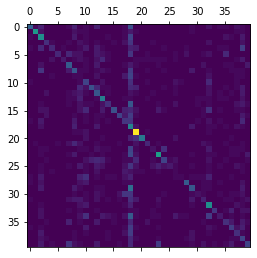

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(test_labels,prediction));
print(classification_report(test_labels,prediction));
cm_train = confusion_matrix(test_labels,prediction);
plt.matshow(cm_train);

**For Single Images HAR Pipeline**

In [ ]:
  from google.colab.patches import cv2_imshow

  def draw_boxesV2(filename, v_boxes, v_labels, v_scores):

    img = cv2.imread(filename)
    print(img.shape)

    for i in range(len(v_boxes)):
      box = v_boxes[i]
      y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
      width, height = x2 - x1, y2 - y1
      if v_labels[i] == "person":
        cropped_img = img[y1:y2,x1:x2]
        cv2_imshow(cropped_img)

        classify_image(cropped_img)


In [ ]:
from numpy import expand_dims
def load_image_pixels(filename, shape):
  # load image to get its shape
  image = load_img(filename)
  width, height = image.size

  # load image with required size
  image = load_img(filename, target_size=shape)
  image = img_to_array(image)

  # grayscale image normalization
  image = image.astype('float32')
  image /= 255.0

  # add a dimension so that we have one sample
  image = expand_dims(image, 0)
  return image, width, height

In [ ]:
def classify_image(image):

  # define the expected input shape for the model
  input_w, input_h = pixels, pixels

  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

  # make prediction
  yhat = model.predict(image)

  #print(cam.shape)
  print(yhat.shape)
  category = np.argmax(yhat)
  print(category)
  print(HARLabels[category])
  


Saving running.jpg to running.jpg
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.95192885398865
person 99.9376893043518
(1422, 2560, 3)


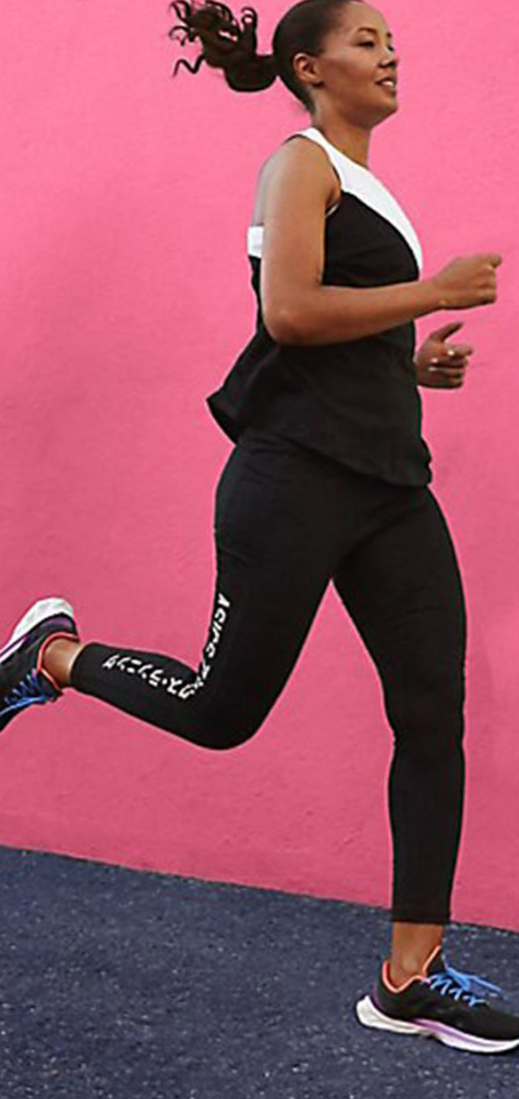

(1, 40)
27
running


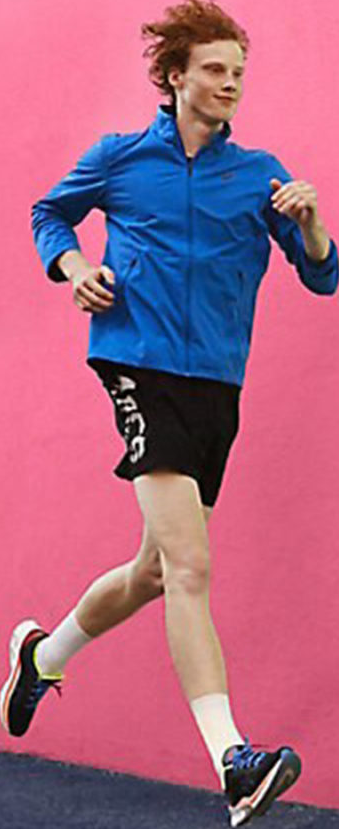

(1, 40)
27
running


In [ ]:
from google.colab import files 
upload = files.upload()

for fn in upload.keys():
  photo_filename = '/content/' + fn

  # define the expected input shape for the model
  input_w, input_h = 416, 416

  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

  # make prediction
  yhat = YoloModel.predict(image)
  # summarize the shape of the list of arrays
  print([a.shape for a in yhat])
  
  boxes = list() 
  for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
 
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

  # suppress non-maximal boxes
  do_nms(boxes, 0.5)

  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

  # summarize what we found
  for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
  
  # draw what we found
  draw_boxesV2(photo_filename, v_boxes, v_labels, v_scores)

**Above is the Pipeline**

In [ ]:
from google.colab import files 
upload = files.upload()

for fn in upload.keys():
  photo_filename = '/content/' + fn

  # define the expected input shape for the model
  input_w, input_h = pixels, pixels

  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

  # make prediction
  yhat = model.predict(image)

  #print(cam.shape)
  print(yhat.shape)
  category = np.argmax(yhat)
  print(category)
  print(labels[category])
  


Saving phoning_049.jpg to phoning_049.jpg
(1, 40)
18
phoning


Above tested

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

def predict_image(file, model, mapping):
    
    # load an image from file
    image = load_img(file, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    cam, yhat = model.predict(image)
    print(cam.shape)
    print(yhat.shape)
    category = np.argmax(yhat)
    return mapping[category]

In [ ]:
cam_shape = tuple(model.get_layer("ClassConv").output.get_shape().as_list()[1:])


# custom generator
def multiple_outputs(generator, image_dir, batch_size, image_size):
    gen = generator.flow_from_directory(
        image_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical', shuffle=False)
    
    while True:
        gnext = gen.next()
        # return image batch and 3 sets of lables
        #yield gnext[0], [np.zeros((gnext[1].shape[0], 14, 14, 1024)), gnext[1]]
        yield gnext[0], [np.zeros((gnext[1].shape[0], *cam_shape)), gnext[1]]

In [ ]:
BATCH_SIZE = 1450

pixels = 500
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory("/content/gdrive/MyDrive/standford_tvt_ds_seed_13_test", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical', shuffle=False)
y_true = test_gen.classes

test_m = len(test_gen.classes)

mapping = dict()
for activity, idx in test_gen.class_indices.items():
    mapping[idx] = activity


test_steps = math.ceil(test_m/BATCH_SIZE)

Found 213 images belonging to 40 classes.


In [ ]:
predictions = model.predict_generator(test_gen, test_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
predictions = predictions.argmax(axis=1)

In [ ]:
len(predictions)

213

In [ ]:
(y_true == predictions).mean()

0.6431924882629108

In [ ]:
matrix = metrics.confusion_matrix(y_true, predictions)

In [ ]:
test_labels = test_gen.classes;
test_gen.class_indices;

prediction = model.predict_generator(test_gen,test_steps);
prediction = prediction.argmax(axis =1);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


In [ ]:
prediction.size

213

0.6431924882629108
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.83      1.00      0.91         5
           2       1.00      0.67      0.80         6
           3       0.50      0.20      0.29         5
           4       0.75      0.75      0.75         4
           5       0.50      0.25      0.33         4
           6       0.71      1.00      0.83         5
           7       0.80      0.67      0.73         6
           8       0.60      0.60      0.60         5
           9       1.00      0.75      0.86         4
          10       0.33      0.40      0.36         5
          11       0.83      0.83      0.83         6
          12       1.00      0.60      0.75         5
          13       0.80      0.80      0.80         5
          14       1.00      0.40      0.57         5
          15       0.50      0.20      0.29         5
          16       1.00      0.40      0.57         5
        

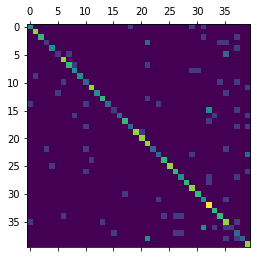

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(test_labels,prediction));
print(classification_report(test_labels,prediction));
cm_train = confusion_matrix(test_labels,prediction);
plt.matshow(cm_train);